In [1]:
import pandas as pd
import warnings
# Ignore Warning Messages
warnings.filterwarnings(action='ignore')

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
lb = pd.read_csv('./data/loan_before.csv')

# 문제 정의

## 어떤 요소가 대출상환여부에 영향을 "많이" 미치는가?
## 그 요소들이 대출상환여부에 어떠한 영향을 미치는가? (선형, 비선형 등등) 

# 방법론

## 분석과정
### 문제를 해결하기 위해 설명가능한 머신러닝(xAI)를 활용
### Process
1. Features Engineering
2. Machine Learning Model
3. Shap value를 통해 어떤 변수가 가장 큰 영향을 주는지 알아냄
4. 영향이 큰 5개의 변수들과 대출상환여부에 관계에 대해 알아봄

## Feature Engineering

<ul>
<li>AMT_CREDIT = 갚아야 하는 금액</li>
<li>AMT_ANNUITY = 1달마다 내야하는 금액</li>
<li>AMT_CREDIT_ANNUITY_RATIO = 총 갚아야 하는 기간(달)</li>
</ul>

In [3]:
train.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,...,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR
0,162716,0,0.0,0,1,0,101250.0,480060.0,22509.0,Unaccompanied,...,-2256,NaN,2.0,15,Kindergarten,NaN,0.665732,NaN,-139.0,1.0
1,361317,0,0.0,0,1,2,225000.0,237024.0,12231.0,Unaccompanied,...,-4133,NaN,4.0,3,Business Entity Type 3,0.575699,0.535140,0.670652,-957.0,0.0
2,246925,0,1.0,0,0,0,171000.0,247675.5,26005.5,Unaccompanied,...,-4340,NaN,2.0,10,Business Entity Type 3,0.092273,0.002272,0.154744,-827.0,1.0
3,294331,0,1.0,1,0,0,225000.0,180000.0,9000.0,Unaccompanied,...,-1621,12.0,2.0,12,Trade: type 7,0.221815,0.120444,NaN,-569.0,2.0
4,152173,0,0.0,0,1,0,180000.0,337500.0,12852.0,Unaccompanied,...,-2870,NaN,1.0,12,XNA,NaN,0.722415,0.723837,-1544.0,4.0


In [4]:
train['AMT_CREDIT_ANNUITY_RATIO'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']
test['AMT_CREDIT_ANNUITY_RATIO'] =  test['AMT_CREDIT'] /  test['AMT_ANNUITY']

<strong> ID별로 groupby 와 mean()을 통해 평균을 구했다 </strong>
<ul>
    <li>AMT_CREDIT_SUM: 총 빌린 돈의 평균</li>
    <li>CNT_CREDIT_PROLONG: 연체된 평균 횟수</li>
    <li>CNT_CREDIT: home credit보다 전에 받은 대출이 평균적으로 며칠 전에 받은 대출인지</li>
</ul>
<strong> ID별로 groupby해서 총 몇번 대출 했는지 구함 </strong>
    <li>COUNT: 이전에 총 몇 번 대출을 받았는지</li>

In [5]:
train = pd.merge(train, lb.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].mean().reset_index(), how='left', on ='SK_ID_CURR')
test = pd.merge(test, lb.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].mean().reset_index(), how='left', on ='SK_ID_CURR')

train = pd.merge(train, lb.groupby('SK_ID_CURR')['CNT_CREDIT_PROLONG'].mean().reset_index(), how='left', on ='SK_ID_CURR')
test = pd.merge(test, lb.groupby('SK_ID_CURR')['CNT_CREDIT_PROLONG'].mean().reset_index(), how='left', on ='SK_ID_CURR')

train = pd.merge(train, lb.groupby('SK_ID_CURR')['DAYS_CREDIT'].mean().reset_index(), how='left', on ='SK_ID_CURR')
test = pd.merge(test, lb.groupby('SK_ID_CURR')['DAYS_CREDIT'].mean().reset_index(), how='left', on ='SK_ID_CURR')

train = pd.merge(train, lb.groupby('SK_ID_CURR').size().reset_index().rename(columns={0:"COUNT"}), how='left', on ='SK_ID_CURR')
test = pd.merge(test, lb.groupby('SK_ID_CURR').size().reset_index().rename(columns={0:"COUNT"}), how='left', on ='SK_ID_CURR')

모델을 해석하는 것이 목적이기 때문에 해석목적에 방해가 되는 범주형(카테고리형) 데이터를 제거한다. <br>
<strong> 이것이 정확히 어떤 뜻이냐? <br>
- 범주형 데이터 (0 or 1)가 같은 변수로 시각화를 할 경우 해석(분석)하기가 매우 곤란한 경우가 많다. <br>
따라서 수치형 데이터를 가지고 모델을 그려야 시각화한 그래프를 해석하기 편하다
- EXT_SOURCE는 kaggle에서 제공한 데이터인데 우리는 정확히 이 데이터가 어떤 의미를 가지고 어떤 유형인지 모르므로 제거함

In [6]:
del_list = ['SK_ID_CURR', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
           'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'ORGANIZATION_TYPE',
           'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
train = train.drop(del_list, axis=1)
test = test.drop(del_list, axis=1)

<br>

| Column |  Meaning |
|----------------|----------------------------------|
|SK_ID_CURR | Unique ID | 
|TARGET| Target(0: X Problem, 1: Problem) |
|CODE_GENDER|Sex(0: Female, 1: Male) | 
|FLAG_OWN_CAR|Car(0: not own, 1: own) | 
|FLAG_OWN_REALTY|Real estate(0: not own, 1: own) | 
| CNT_CHILDREN|Number of Child |
| AMT_INCOME_TOTAL|Income |
|AMT_CREDIT|Loan amount | 
|AMT_ANNUITY|Monthly amount to pay | 
|NAME_TYPE_SUITE|Companion  | 
|NAME_INCOME_TYPE|Type of job | 
|NAME_EDUCATION_TYPE|Academic degree | 
|NAME_HOUSING_TYPE|Residential situation | 
|REGION_POPULATION_RELATIVE|Local population | 
|DAYS_BIRTH|Age | 
|DAYS_EMPLOYED|When one was employed | 
|OWN_CAR_AGE|Car's age | 
|CNT_FAM_MEMBERS|Number of family member | 
|HOUR_APPR_PROCESS_START |Time when one applied for loans | 
|ORGANIZATION_TYPE|Type of organization one works in | 
|EXT_SOURCE_1|Credit score from outer source1 | 
| EXT_SOURCE_2|Credit score from outer source2 |
|EXT_SOURCE_3|Credit score from outer source3 | 
|DAYS_LAST_PHONE_CHANGE|Last time one changed the phone | 
|AMT_REQ_CREDIT_BUREAU_YEAR |The number of credit information inquiry<br>in one year prior to the application | 


## Modeling

### shap value를 이용해서 모델을 해석할 때 "상관계수"가 높은 변수들이 있으면 해석에 방해가 되므로 상관계수가 높은 변수 중 하나를 모델링 전에 미리 없앤다
#### input 변수가 상관관계가 높다면 shap value는 제대로 된 설명력을 가지기 힘들다

<AxesSubplot:>

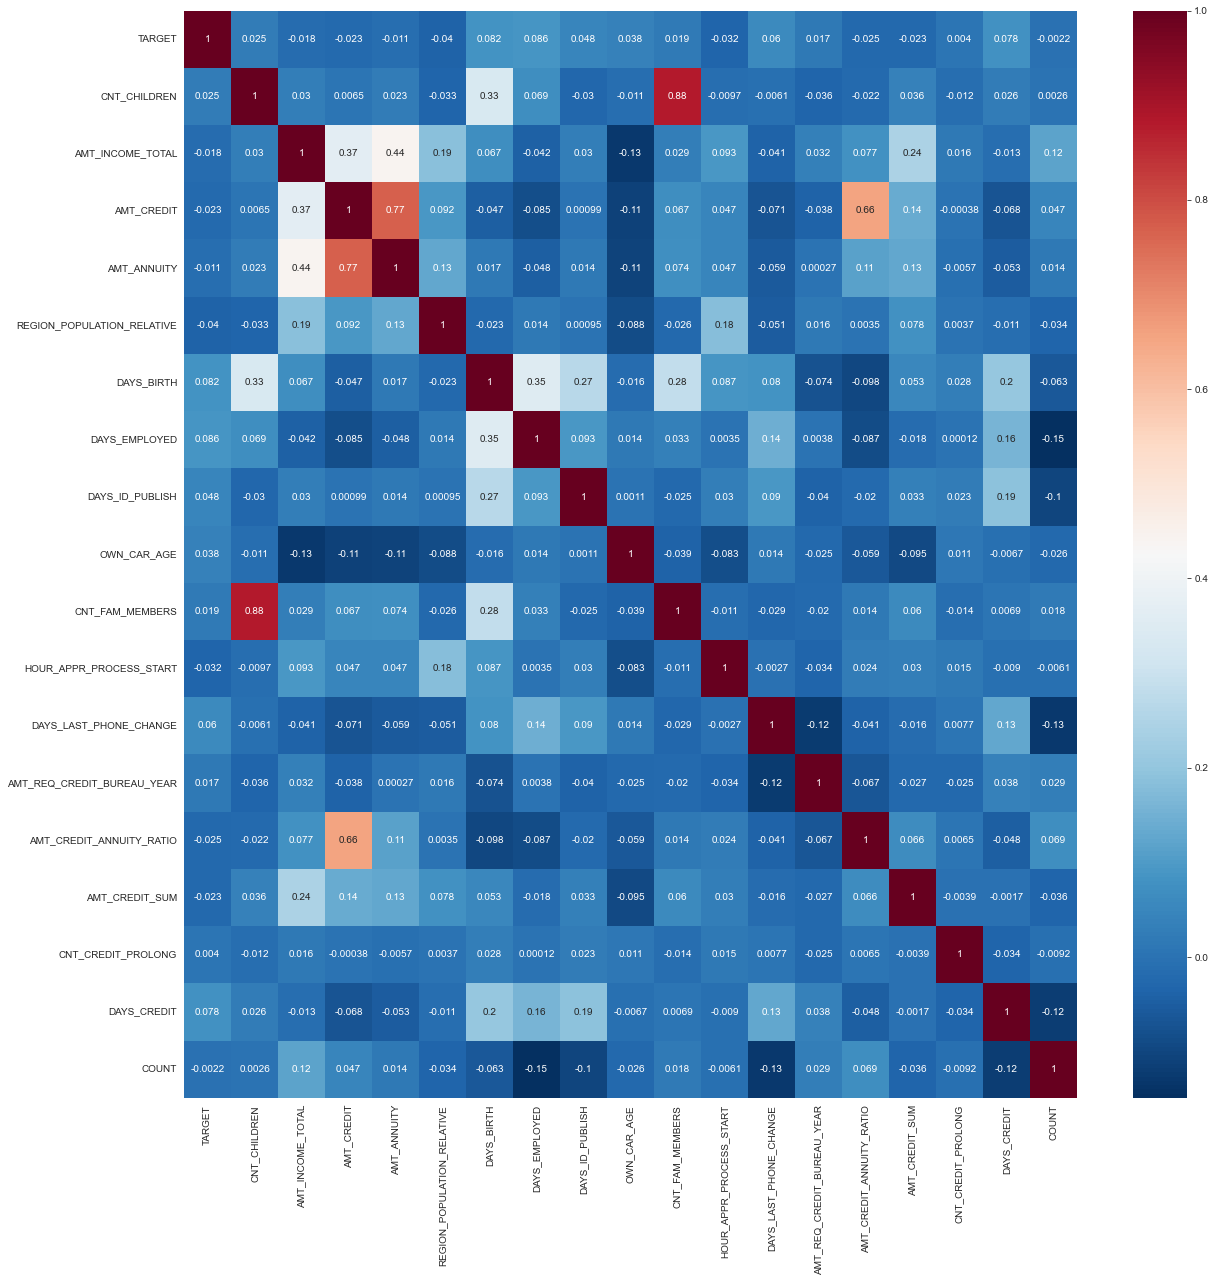

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
df = train.corr()
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df, annot=True, cmap='RdBu_r')

<strong> 높은 상관성을 띄는 변수 pairs </strong><br>
<ul>
    <li>CNT_FAM_MEMBERS,          CNT_CHILDREN</li>
    <li>AMT_CREDIT_ANNUITY_RATIO, AMT_CREDIT</li>
    <li>AMT_ANNUITY,              AMT_CREDIT</li>
</ul

#### CNT_CHILDREN과 TARGET의 상관계수가 더 높으므로 CNT_FAM_MEMBERS를 지운다
#### AMT_CREDIT_ANNUITY_RATIO과 TARGET의 상관계수가 더 높으므로 AMT_CREDIT를 지운다
#### AMT_CREDIT을 지우므로 AMT_ANNUITY와 AMT_CREDIT의 관계는 알아보지 않아도 된다

In [8]:
CNT_FAM_MEMBETRS=train['CNT_FAM_MEMBERS'].corr(train['TARGET'])
CNT_CHILDREN=train['CNT_CHILDREN'].corr(train['TARGET'])
AMT_CREDIT_ANNUITY_RATIO = train['AMT_CREDIT_ANNUITY_RATIO'].corr(train['TARGET'])
AMT_CREDIT = train['AMT_CREDIT'].corr(train['TARGET'])
                                                                        
print(f'CNT_FAM_MEMBERS-TARGET corr: {CNT_FAM_MEMBETRS:.5f}')
print(f'CNT_CHILDREN corr: {CNT_CHILDREN:.5f}')
print(f'AMT_CREDIT_ANNUITY_RATIO-TARGET corr: {AMT_CREDIT_ANNUITY_RATIO:.5f}')
print(f'AMT_CREDIT corr: {AMT_CREDIT:.5f}')


CNT_FAM_MEMBERS-TARGET corr: 0.01888
CNT_CHILDREN corr: 0.02536
AMT_CREDIT_ANNUITY_RATIO-TARGET corr: -0.02474
AMT_CREDIT corr: -0.02256


In [9]:
train = train.drop(['CNT_FAM_MEMBERS', 'AMT_CREDIT'], axis=1)

### XGBoost를 이용하여 모델구축 후 훈련
#### Shap value를 얻어내기 위해서는 tree 기반의 모델을 사용해야한다. RF, XGB, lightGBM 등이 있지만 XGB가 비교적 빠른 속도와 높은 정확성을 가지고 있기 때문에  사용

In [10]:
from xgboost import XGBClassifier

target = train['TARGET']
train = train.drop('TARGET', axis=1)
model = XGBClassifier(n_estimators=100, learning_rate=0.1, eval_metric='logloss')
model.fit(train, target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=10,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## SHAP value 활용

In [11]:
import shap

shap_values = shap.TreeExplainer(model).shap_values(train)

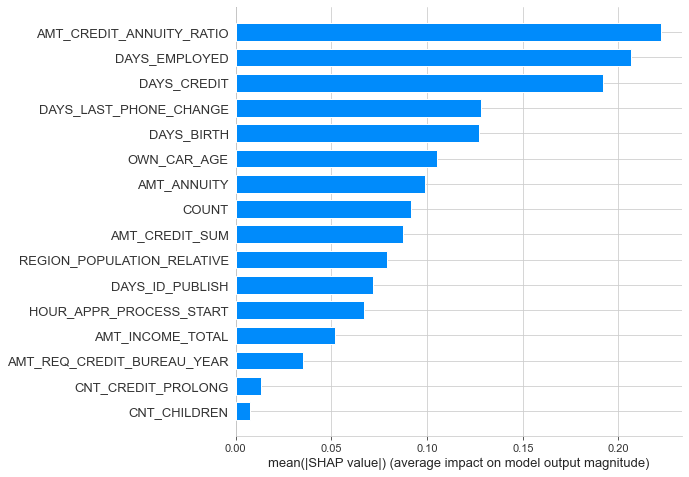

In [12]:
shap.summary_plot(shap_values, train, plot_type='bar')

시각화 결과 대출금 상환 여부에 가장 큰 영향을 끼치는 요인 5가지는
<ul>
    <li style="font-size:20px">DAYS_CREDIT: 전에 또 언제 대출을 받았는지</li>
    <li style="font-size:20px">DAYS_EMPLOYED: 직장을 며칠 전에 가졌는지</li>
    <li style="font-size:20px">AMT_CREDIT_ANNUITY_RATIO: 몇 달 동안 갚아야 하는지</li>
    <li style="font-size:20px">DAYS_BIRTH: 며칠 전에 태어났는지 = 나이</li>
    <li style="font-size:20px">DAYS_LAST_PHONE_CHANGE: 마지막으로 언제 핸드폰을 바꿨는지</li>
 <ul>

## 영향을 많이 주는 5가지 변수와 상환 여부의 관계
기본적으로 TARGET:0 문제없음, TARGET:1 문제있음 이므로 y축인 SHAP value가 낮을수록 문제가 없다고 판단한다

<strong style="font-size:20px"> 1. DAYS_CREDIT 와의 관계 </strong>
<div> linear한 모습을 보이고, 최근 1000일 동안 대출기록이 있으면 상환율이 계속 급감한다</div>
<div> 최근 1000일 이후에 대출기록이 있으면 상환율이 높은 성향을 띈다</div>


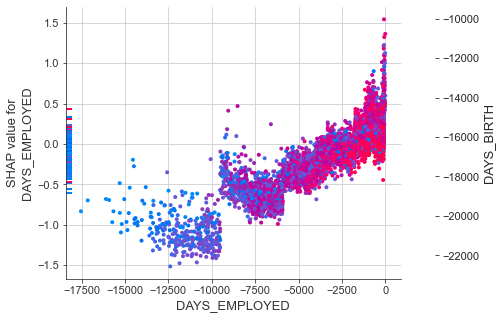

In [13]:
shap.dependence_plot('DAYS_EMPLOYED', shap_values, train)

<strong style="font-size:20px"> 2. DAYS_EMPLOYED 와의 관계 </strong>
<div>linear한 성향을 띈다</div>
<div>대출 2500일 전에 직장을 잡았으면 대체로 문제가 없고 최근에 직장을 잡아을수록 상환율이 급감한다</div>

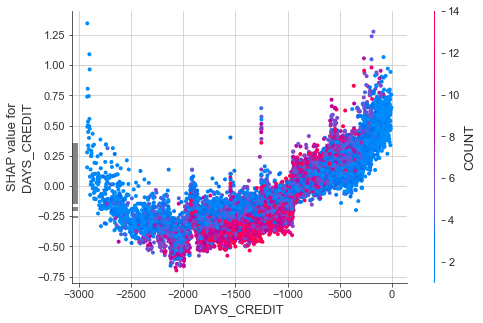

In [14]:
shap.dependence_plot('DAYS_CREDIT', shap_values, train)

<strong style="font-size:20px"> 3. AMT_CREDIT_ANNUITY_RATIO 와의 관계 </strong>
<div>갚아야 할 기간이 12~21개월이면 상환율이 낮아지고, 1~12 , 21~ 이면 상환율이 높아진다</div>

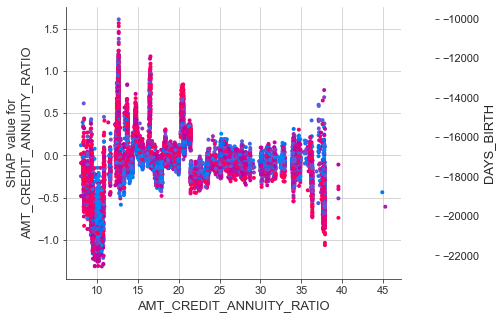

In [15]:
shap.dependence_plot('AMT_CREDIT_ANNUITY_RATIO', shap_values, train)

<strong style="font-size:20px"> 4. DAYS_BIRTH 와의 관계 </strong>
<div>linear한 성향을 띈다</div>
<div>나이가 많을수록 상환율이 계속 커진다.</div>
<div>20~27살까지 상환율이 조금 높다가 27살 이후에 급등하고 계속 내려가는 성향을 띔</div>


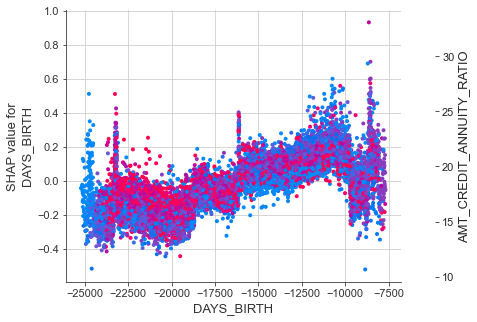

In [16]:
shap.dependence_plot('DAYS_BIRTH', shap_values, train)


<strong style="font-size:20px"> 5. DAYS_LAST_PHONE_CHANGE 와의 관계 </strong>
<div>linear한 성향을 띈다</div>
<div>대출 1,000일 전에 핸드폰을 바꿨으면 대체로 문제가 없고 최근에 새로 샀을 경우 상환율이 급감한다</div>

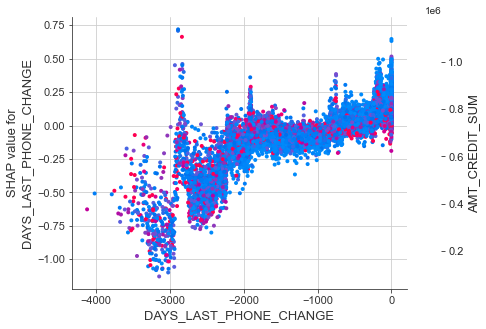

In [17]:
shap.dependence_plot('DAYS_LAST_PHONE_CHANGE', shap_values, train)

# 결론

1. [ DAYS_CREDIT: 전에 또 언제 대출을 받았는지 ] 변수가 가장 큰 영향을 가졌다(상관관계가 크지만 이것이 곧 인과관계를 뜻하지는 않는다)

2. 자식 수와 대출연장 횟수는 상환율에 아주 미비한 영향을 미쳤다.

3. 최근에 대출을 받고, 최근에 취직을 하고, 나이가 어리고, 최근에 핸드폰을 바꿨을수록 상환율이 낮다


## 결론에 대한 시각화

<div>group1 = 최근대출일자, 나이, 마지막 핸드폰 바꾼 일자, 취직 일자 상위 25% (즉, 최근에 대출, 나이 적음, 최근에 핸드폰 바꿈, 최근에 취직)</div>
<div>group2 = 최근대출일자, 나이, 마지막 핸드폰 바꾼 일자, 취직 일자 하위 25% (즉, 상대적으로 늦게 대출, 나이 많음, 오래전에 핸드폰 바꿈, 오래전에 취직)</div>
<br>
<div>.quantile(0.75) == 하위 75%에 해당하는 값을 도출한다. 이 값보다 큰 값들은 상위 25%에 해당</div>
<div>.quantile(0.25) == 하위 25%에 해당하는 값을 도출한다. 이 값보다 작은 경우는 하위 25%에 해당</div>
<br>
<div>group1에 1을 표기</div>
<div>group2에 0을 표기</div>

In [18]:
train['TARGET'] = target
cond1 = train['DAYS_CREDIT'].quantile(0.75) < train['DAYS_CREDIT']
cond2 = train['DAYS_BIRTH'].quantile(0.75) < train['DAYS_BIRTH']
cond3 = train['DAYS_LAST_PHONE_CHANGE'].quantile(0.75) < train['DAYS_LAST_PHONE_CHANGE']
cond4 = train['DAYS_EMPLOYED'].quantile(0.75) < train['DAYS_EMPLOYED']

cond_1 = train['DAYS_CREDIT'].quantile(0.25) > train['DAYS_CREDIT']
cond_2 = train['DAYS_BIRTH'].quantile(0.25) > train['DAYS_BIRTH']
cond_3 = train['DAYS_LAST_PHONE_CHANGE'].quantile(0.25) > train['DAYS_LAST_PHONE_CHANGE']
cond_4 = train['DAYS_EMPLOYED'].quantile(0.25) > train['DAYS_EMPLOYED']

group1 = train[cond1  & cond2  & cond3  & cond4 ]
group1['group'] = 1
group2 = train[cond_1 & cond_2 & cond_3 & cond_4]
group2['group'] = 2
total = group1.append(group2)

<div style="font-size: 25px">예상대로 group1의 상환문제가 있는 평균(0.15)이, group2의 상환문제가 있는 평균(0.025)보다 높았다</div>

<AxesSubplot:xlabel='group', ylabel='TARGET'>

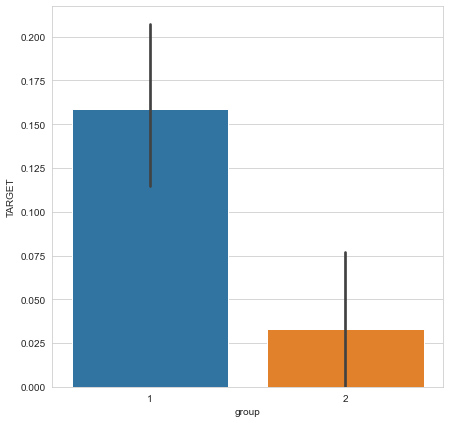

In [19]:
fig, ax = plt.subplots(figsize=(7,7))
sns.barplot(data=total, x='group', y='TARGET')